In [1]:
from functions_untrained_reservoir import *

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer
from reservoirpy.observables import spectral_radius

import numpy as np 
import matplotlib.pyplot as plt

### Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    
 Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir non entrainé.
 
à noter, que la méthode d'entrainement utilisée pour ce script est une méthode dite online utilisant le noeud FORCE de ReservoirPy. Et qu'un autre script traite de la méthode offline pour pouvoir comparer les résultats obtenus.

Données générales 

In [2]:
data = extract_data() #Données d'entrée
transcription = extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [3]:
N = 210 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.8 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
connectivity = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(connectivity*N)
mu = 0
I0 = 0.005 #pendant l'entrainement de la sortie            #Non utilisée


Wo = normal(loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie : Non utilisée


Création de la matrice du réservoir : avec pas d'autapses

In [4]:
W_r.init = Initializer(W_r)

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [5]:
Win = W_in(N,M)

## expérience

Création des données pour l'entrainement

In [6]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            X_input.append(np.transpose(formatage_cocleogram(indS, indU, indD,data)))
            X_target.append(target_xyz(indS, indU, indD,data))

Création du réservoir

In [7]:
reservoir_online, readout_online = Reservoir(units = N,
                                               lr = lr,
                                               sr=sr,
                                               W=W_r.init,
                                               Win=Win,
                                               equation="external",
                                               input_bias=False,
                                               noise_rc = I0), FORCE()
esn_online = reservoir_online >> readout_online


Entrainement du réservoir

In [8]:
#entrainement du réservoir
for i in range(len(X_input)) : 
    esn_online.train(X_input[i],X_target[i],reset = True)

Récupération des poids de sortie

1.122862914018773


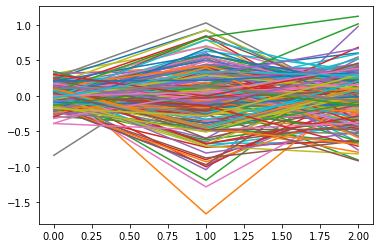

In [9]:
poids_sortie = readout_online.get_param("Wout")
plt.plot(np.transpose(poids_sortie))
print(np.max(poids_sortie))

### Test 1 
Test du réservoir sur des données d'entrainements

###### 1 chiffre

In [10]:
#Test du réservoir
indS,indU,indD = 1,3,6
X_test = np.transpose(formatage_cocleogram(indS,indU,indD,data))
xyz = esn_online.run(X_test)
    
#récupération des états des neurones
states = etat(reservoir_online,indS,indU,indD,data)

#récupération de l'erreur commise
erreur = error(xyz,indS,indU,indD,data)

Running Model-0: 1886it [00:00, 7579.08it/s]                                                                           
Running Reservoir-0: 100%|██████████████████████████████████████████████████████| 1886/1886 [00:00<00:00, 11522.93it/s]


In [18]:
np.shape(xyz)

(1919, 3)

Affichage du résultat

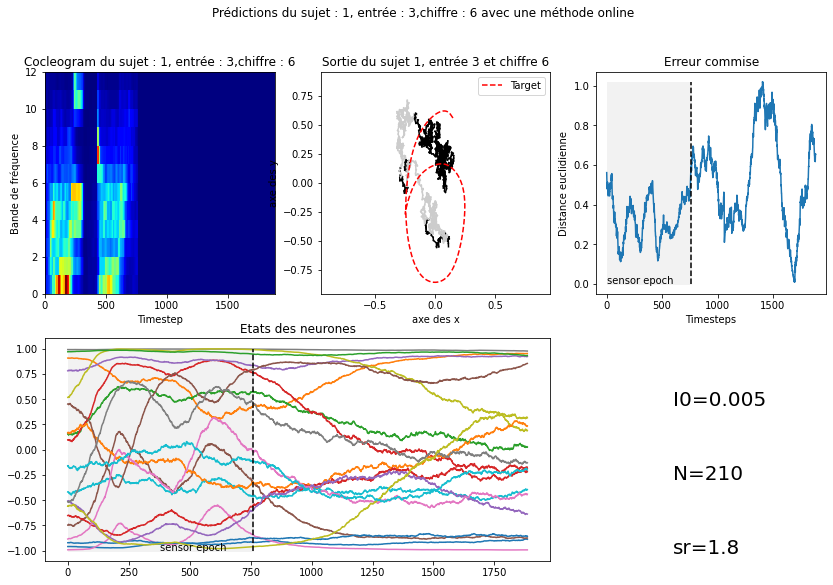

In [11]:
#affichage des résultats
affiche(xyz,indS,indU,indD,data,states,erreur,mode = "online",sr = sr,N=N,I0 = I0)

###### 10 chiffres

In [12]:
#Test du réservoir sur les 10 chiffres:
liste_chiffre=[]
indS, indU = 1,1
for i in range(10):
    X_test = np.transpose(formatage_cocleogram(indS,indU,i,data))
    liste_chiffre.append(esn_online.run(X_test))

Running Model-0: 1671it [00:00, 7417.40it/s]                                                                           
Running Model-0: 970it [00:00, 7811.60it/s]                                                                            
Running Model-0: 1512it [00:00, 7608.19it/s]                                                                           
Running Model-0: 1790it [00:00, 7605.62it/s]                                                                           
Running Model-0: 1295it [00:00, 7632.86it/s]                                                                           
Running Model-0: 1931it [00:00, 6614.95it/s]                                                                           
Running Model-0: 1886it [00:00, 7572.60it/s]                                                                           
Running Model-0: 1395it [00:00, 7592.97it/s]                                                                           
Running Model-0: 1566it [00:00, 7371.15i

Affichage du résultat

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_untrained_reservoir.py:289: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


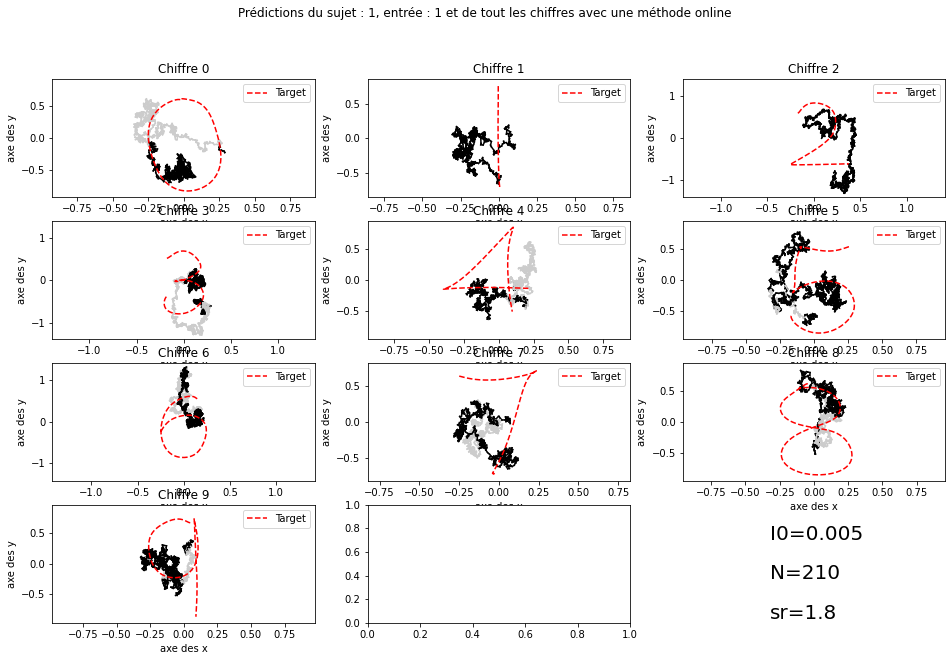

In [13]:
affiche_chiffre(liste_chiffre,indS,indU,data,mode="online",sr = sr,N=N,I0 = I0)

### Test 2 
On test le réservoir sur des données non entrainées

###### 1 chiffre

In [14]:
#Test du réservoir
indS,indU,indD = 1,4,6
X_test = np.transpose(formatage_cocleogram(indS,indU,indD,data))
xyz = esn_online.run(X_test)
   
#Récuperation des états des neurones
states = etat(reservoir_online,indS,indU,indD,data)

#Récupération de l'erreur commise (distance euclidienne ici)
erreur = error(xyz,indS,indU,indD,data)

Running Model-0: 1919it [00:00, 7170.11it/s]                                                                           
Running Reservoir-0: 100%|██████████████████████████████████████████████████████| 1919/1919 [00:00<00:00, 10178.52it/s]


Affichage du chiffre

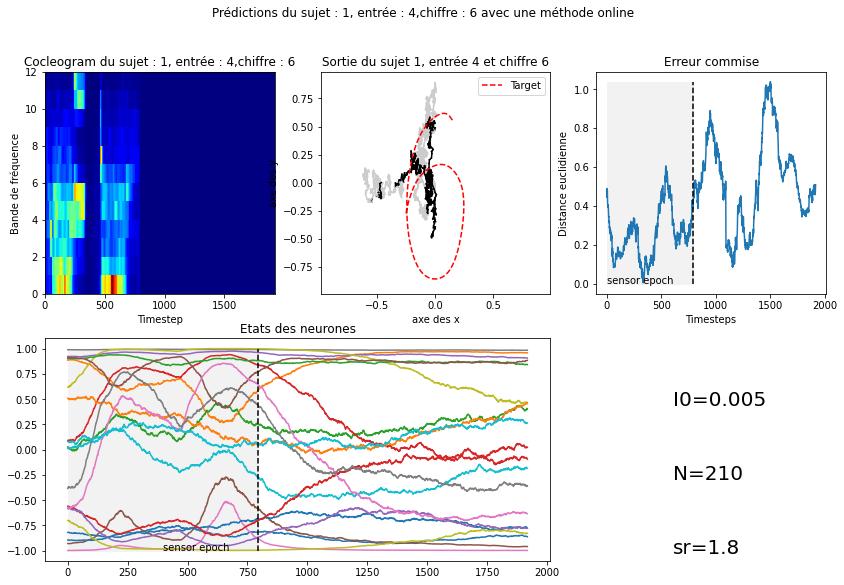

In [15]:
affiche(xyz,indS,indU,indD,data,states,erreur,mode = "online",sr = sr,N=N,I0 = I0)

###### 10 chiffres

In [16]:
#Test du réservoir sur les 10 chiffres:
liste_chiffre=[]
indS, indU = 1,5
for i in range(10):
    X_test = np.transpose(formatage_cocleogram(indS,indU,i,data))
    liste_chiffre.append(esn_online.run(X_test))

Running Model-0: 1752it [00:00, 6617.53it/s]                                                                           
Running Model-0: 901it [00:00, 5701.25it/s]                                                                            
Running Model-0: 1408it [00:00, 5952.89it/s]                                                                           
Running Model-0: 1753it [00:00, 6074.48it/s]                                                                           
Running Model-0: 1271it [00:00, 6377.71it/s]                                                                           
Running Model-0: 1891it [00:00, 6383.59it/s]                                                                           
Running Model-0: 1873it [00:00, 6392.92it/s]                                                                           
Running Model-0: 1447it [00:00, 6495.09it/s]                                                                           
Running Model-0: 1677it [00:00, 6083.01i

Affichage du résultat

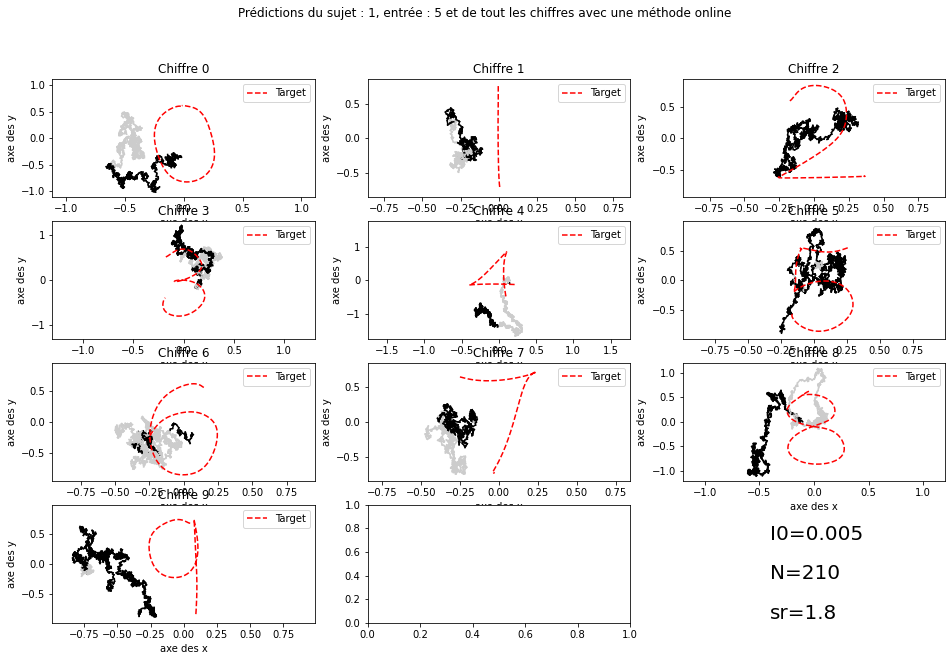

In [17]:
affiche_chiffre(liste_chiffre,indS,indU,data,mode="online",sr = sr,N=N,I0 = I0)

###### Ce qui a bloqué 

Informations pas claires, par exemple on ne sait pas trop quand utiliser le bruit ou non.
Pas de schéma des résultats des réservoirs non entrainés, donc on ne peu pas juger de la cohérence de notre modèle.

# Conclusion

Dans un premier temps nous avons voulu seulement entrainé la sortie de notre réseau. La sortie est entrainé avec une méthode online et avec du bruit (valeur non donnée) est continuellement injecté dans le réservoir pendant l'entrainement.
De plus chaques données étaient entrainées 25 fois (ici je l'ai pas fais sinon mon ordinateur tourne pendant quelques heures).

Nous avons pu remarquer que les résultats étaient peu cohérents avec la target.
De plus, après des tests avec les mêmes valeurs sur un réservoir offline, on remarque que la méthode offline marche "mieux". En effet, avec la méthode online on a un overfitting durant l'apprentissage ce qui nécessite un bruit signifiant dans le réservoir mais qui conduit à des plus grandes perturbations.

Les meilleurs résultats ont été obtenus à en changeant nombres de paramètres : 

   - Méthode d'apprentissage offline
   - N = 210
   - Le bruit a été fixé à 0 
   - sr = 1.0
   - Avec du biais
   - Equation dite "external"
    
Evidemment toutes les combinaisons possibles n'ont pas été essayé.
Les chiffres qu'on pouvait apercevoir étaient le 6 et le 5